In [1]:
from omegaconf import OmegaConf
import torch

import gsbm.gaussian_path as gpath_lib
from gsbm.dataset import get_dist_boundary
from gsbm.state_cost import build_state_cost
from gsbm.sde import build_basedrift
from gsbm.plotting import (
    get_fig_axes, 
    plot_scatter, 
    plot_obstacles, 
    plot_gpath,
    show_image,
)


# Crowd navigation

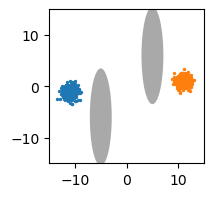

In [2]:
# setup
device = "cuda"
cfg = OmegaConf.load("configs/experiment/stunnel.yaml")
ccfg = cfg.csoc 
sigma = cfg.prob.sigma

# built functions
p0, p1, *_ = get_dist_boundary(cfg)
V = build_state_cost(cfg)
basedrift = build_basedrift(cfg)

# plot boundary
fig, ax = get_fig_axes(ncol=1, ax_length_in=2, lim=cfg.plot.lim)
plot_scatter(ax, p0(512))
plot_scatter(ax, p1(512))
plot_obstacles(ax, cfg.name)


loss=495.1262512207031: 100%|██████████| 1000/1000 [00:11<00:00, 89.19it/s]


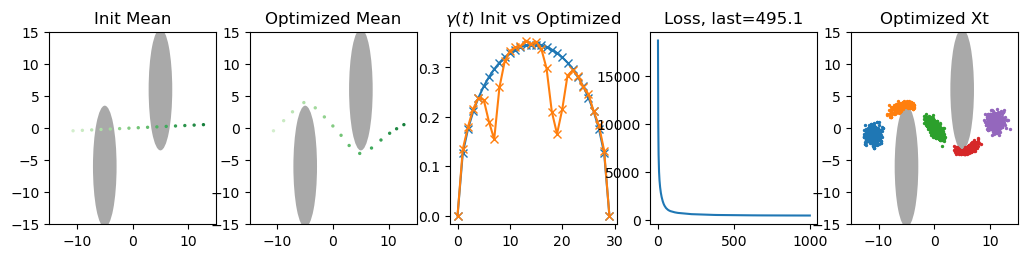

In [3]:
def init_gpath(x0, x1, ccfg):

    B, D = x0.shape
    assert x1.shape == (B, D)

    T, S = ccfg.T_mean, ccfg.T_gamma 

    t = torch.linspace(0, 1, T, device=x0.device)
    tt = t.reshape(1, T, 1)
    xt = (1 - tt) * x0.reshape(B, 1, D) + tt * x1.reshape(B, 1, D)
    assert xt.shape == (B, T, D)

    s = torch.linspace(0, 1, S)
    ys = torch.zeros(B, S, 1)

    return gpath_lib.EndPointGaussianPath(t, xt, s, ys, sigma, basedrift)

B = 1024
gpath = init_gpath(p0(B), p1(B), ccfg).to(device)

loss_fn = gpath_lib.build_loss_fn(gpath, sigma, V, ccfg)
with torch.enable_grad():
    result = gpath_lib.fit(ccfg, gpath, "fwd", loss_fn, verbose=True)
plot_gpath(result, cfg.plot)


# AFHQ

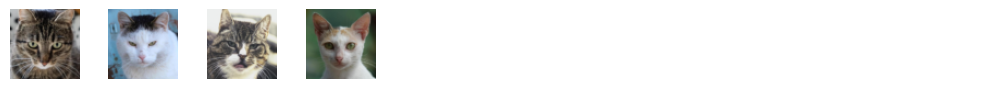

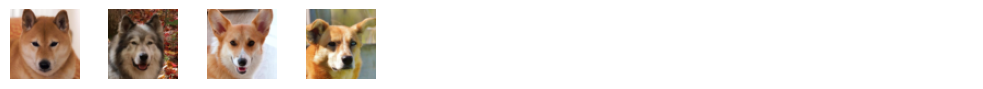

In [2]:
# setup
device = "cuda"
cfg = OmegaConf.load("configs/experiment/afhq.yaml")
cfg.vae.ckpt = "data/vae.ckpt"
ccfg = cfg.csoc 
sigma = cfg.prob.sigma

# built functions
p0, p1, *_ = get_dist_boundary(cfg)
V = build_state_cost(cfg).eval().to(device)
basedrift = build_basedrift(cfg)

# plot boundary
cat_idx = [1219, 1391, 296, 3130] # reproduce fig 14
dog_idx = [458,  139,  182, 1949] # reproduce fig 14
cats = torch.stack([p0.dataset[ii] for ii in cat_idx])
dogs = torch.stack([p1.dataset[ii] for ii in dog_idx])
x0 = cats.reshape(len(cats),-1).to(device)
x1 = dogs.reshape(len(dogs),-1).to(device)

show_image(cats)
show_image(dogs)

In [3]:
def init_gpath(x0, x1, rcfg):

    B, D = x0.shape
    assert x1.shape == (B, D)

    T, S = rcfg.T_mean, rcfg.T_gamma 

    t = torch.linspace(0, 1, T, device=x0.device)
    tt = t.reshape(1, T, 1)
    xt = (1 - tt) * x0.reshape(B, 1, D) + tt * x1.reshape(B, 1, D)
    assert xt.shape == (B, T, D)

    s = torch.linspace(0, 1, S)
    ys = torch.zeros(B, S, 1)

    return gpath_lib.EndPointGaussianPath(t, xt, s, ys, sigma, basedrift)

gpath = init_gpath(x0, x1, ccfg).to(device)
loss_fn = gpath_lib.build_img_loss_fn(gpath, sigma, V, ccfg)
result = gpath_lib.fit(ccfg, gpath, "fwd", loss_fn, verbose=True)

loss=5.5233564376831055: 100%|██████████| 100/100 [00:01<00:00, 86.11it/s]


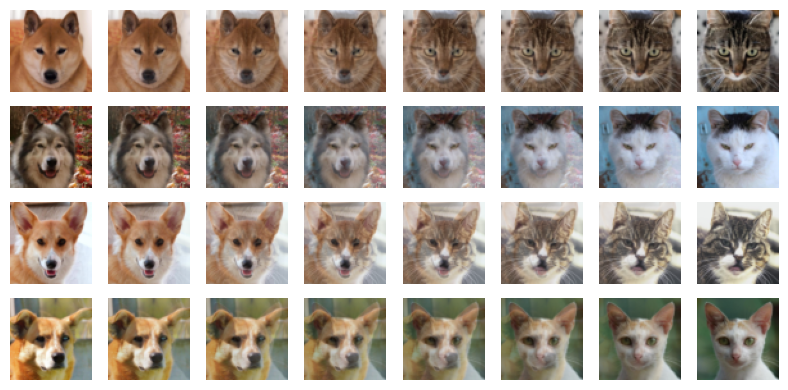

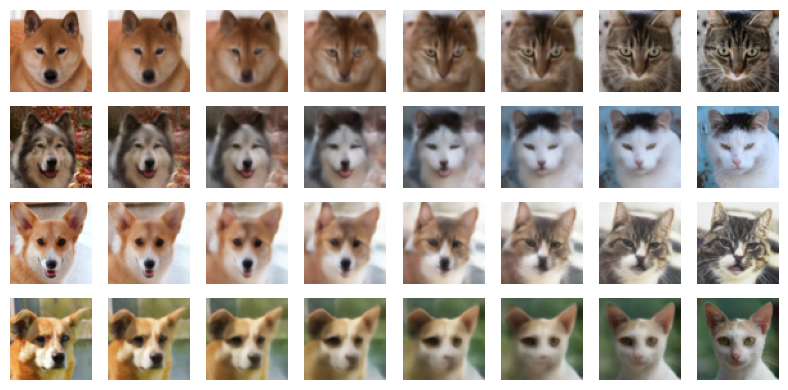

In [4]:
(B, D), T = x0.shape, ccfg.T_mean
sbm = torch.flip(result["init_mean"], dims=[1]).reshape(-1, 3, 64, 64).detach().cpu()
gsbm = torch.flip(result["final_mean"], dims=[1]).reshape(-1, 3, 64, 64).detach().cpu()
show_image(sbm, ncol=T) # standard SB
show_image(gsbm, ncol=T) # our GSBM